#### Jupyter Notebook for importing and plotting ZIP code shapefiles, plotting points from the article 80 and approved datasets, extracting rejected developments from the ZBA dataset, plotting income-based Lorenz curves and finding Gini coefficients for approved and rejected developments by income.

##### Made by Efim Sokolov

#### ZIP code shapes

In [191]:
import geopandas as gpd
import pandas as pd
import contextily as cx # background map
import matplotlib.pyplot as plt

income = gpd.read_file("./ZIP_Codes.geojson")

In [192]:
income.columns
income.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [193]:
import distinctipy
n = income["ZIP5"].count()
colors = distinctipy.get_colors(n)
# distinctipy.color_swatch(colors)
cmap = distinctipy.get_colormap(colors)

#### Approved Dataset

   object_id permitnumber worktype           permittypedescr  \
0          1     A1000569   INTEXT  Amendment to a Long Form   
1          2      A100071      COB  Amendment to a Long Form   
2          3     A1001012    OTHER  Amendment to a Long Form   
3          4     A1001201   INTEXT  Amendment to a Long Form   
4          5      A100137   EXTREN  Amendment to a Long Form   

              description                                           comments  \
0  Interior/Exterior Work  This work is to Amend Permit ALT347244. Elimin...   
1          City of Boston  Change connector link layout from attached enc...   
2                   Other  Amend Alt943748 to erect a roof deck as per pl...   
3  Interior/Exterior Work  Build steel balcony over garden level with sta...   
4  Renovations - Exterior  Landscaping/stonework - amending permit #2801/...   

   declared_valuation  total_fees issued_date expiration_date  ...  \
0            36500.00       390.0  2021-01-28      2021-07-28  .

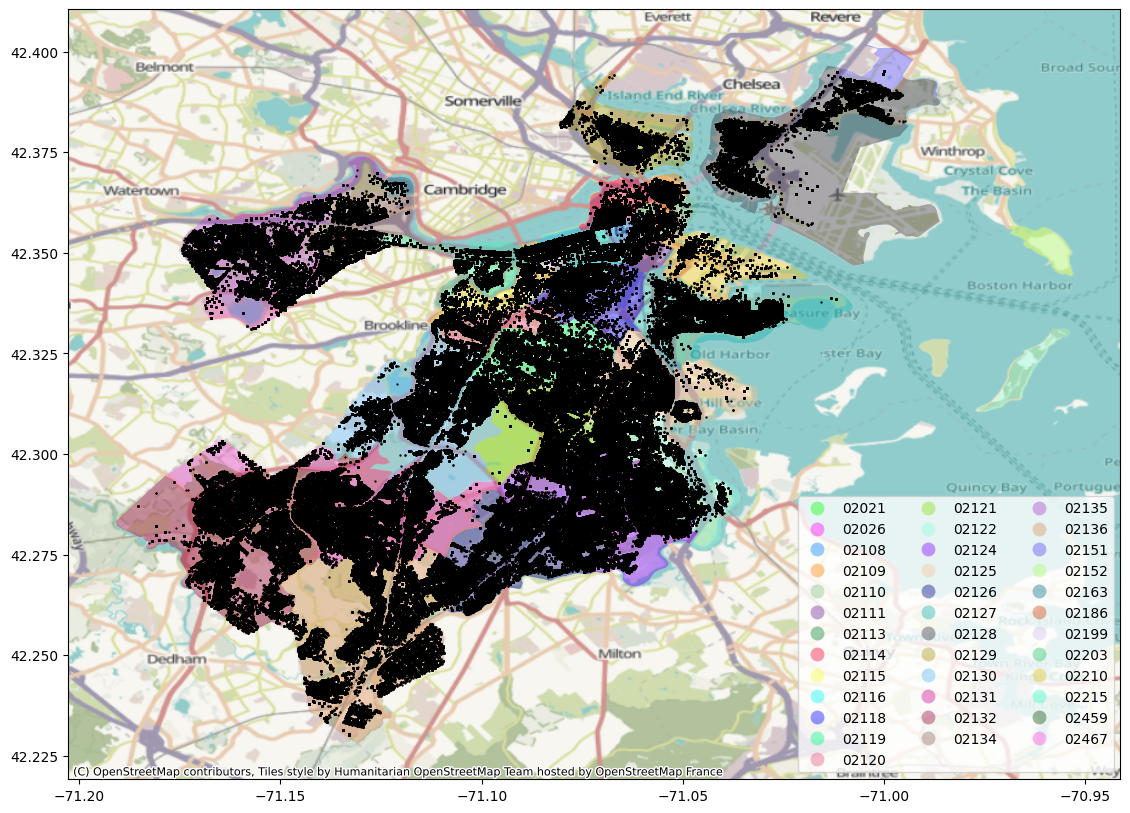

In [194]:
abp = pd.read_csv("./proj_data/cleaned_abp.csv")
abp.dropna(subset=["long", "lat"], inplace=True)
print(abp.head())
gabp = gpd.GeoDataFrame(
    abp, geometry=gpd.points_from_xy(abp["long"], abp["lat"], crs="EPSG:4326")
)
gabp.to_crs(income.crs, inplace=True)
print(f'Number of points {gabp["geometry"].count()}')
ax = income.plot(column="ZIP5", alpha=0.40, categorical=True, legend=True, cmap=cmap, figsize=(20, 10),
            legend_kwds={"loc": "lower right", "ncol": 3})
gabp.plot(ax=ax, markersize=0.4, color="k")
cx.add_basemap(ax, crs=income.crs)

#### Article 80 dataset

   objectid  projectid                                      name  zipcode  \
0     21411       2501          Jackson Square Recreation Center   2119.0   
1     21412       2502                Brooke Charter High School   2124.0   
2     21413       2508                      1000 Boylston Street   2115.0   
3     21414       2509                  Allston Yards Building B   2134.0   
4     21415       2510  Wentworth Multipurpose Academic Building   2215.0   

   neighborhood     recordtype                 status       fdate      badate  \
0       Roxbury            NPC         Board Approved  2016-12-15  2011-06-16   
1      Mattapan  Large Project  Construction Complete  2016-12-09  2017-03-16   
2      Back Bay  Large Project         Board Approved  2017-01-05  2018-03-15   
3       Allston  Large Project         Board Approved  2018-01-22  2019-12-12   
4  Mission Hill  Large Project  Construction Complete  2017-01-13  2017-05-11   

      fbpdate  ... baday fbpyear  fbpmonth fbpday 

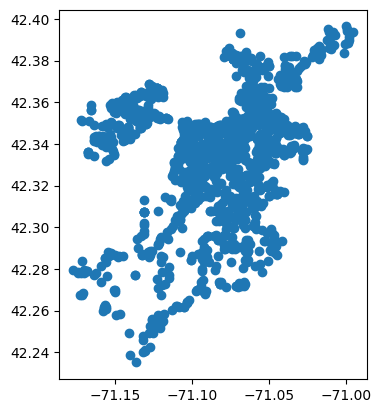

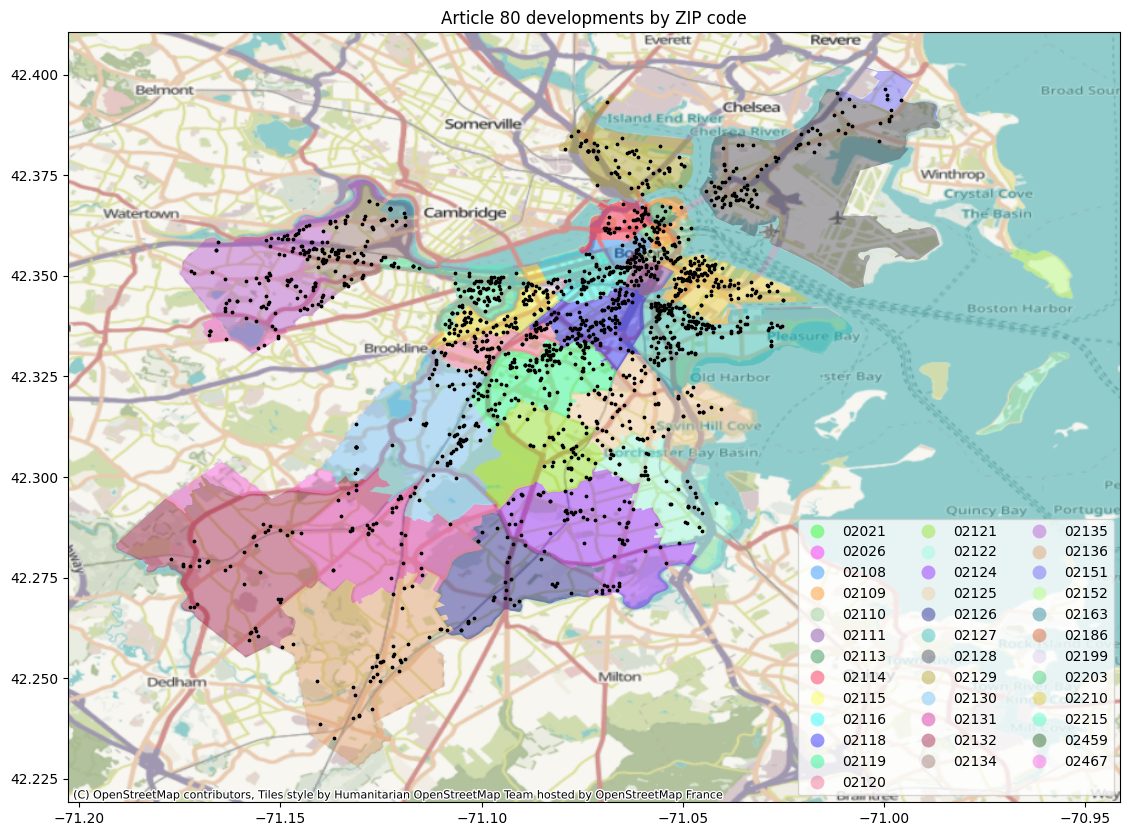

In [195]:
a80 = pd.read_csv("./proj_data/cleaned_a80.csv")
a80.dropna(subset=["lon", "lat"], inplace=True)
print(a80.head())
income.to_crs("EPSG:4326", inplace=True)
lat_range = (42, 43)
lon_range = (-72, -70)
f_a80 = a80[(a80['lat'] >= lat_range[0]) & (a80['lat'] <= lat_range[1]) &
                   (a80['lon'] >= lon_range[0]) & (a80['lon'] <= lon_range[1])]
fa80 = gpd.GeoDataFrame(
    f_a80, geometry=gpd.points_from_xy(f_a80["lon"], f_a80["lat"], crs="EPSG:4326")
)
fa80.plot()
fa80.to_crs(income.crs, inplace=True)
print(f'Number of points {fa80["geometry"].count()}')
ax = income.plot(column="ZIP5", alpha=0.40, categorical=True, legend=True, cmap=cmap, figsize=(20, 10),
            legend_kwds={"loc": "lower right", "ncol": 3})
fa80.plot(ax=ax, markersize=3, color="k")
cx.add_basemap(ax, crs=income.crs)
ax.set_title("Article 80 developments by ZIP code")
plt.savefig("income_zips", bbox_inches='tight')

Spacial Join

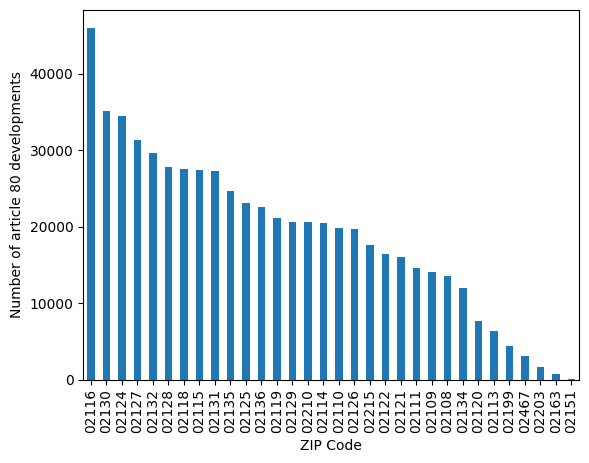

In [196]:
num_per_neighborhood = income.sjoin(gabp, predicate="contains").groupby("ZIP5").size()
# num_per_neighborhood["Harbor Islands"] = 0
ax = num_per_neighborhood.sort_values(ascending=False).plot(kind="bar")
ax.set_xlabel("ZIP Code")
ax.set_ylabel("Number of article 80 developments")
plt.savefig("nums_ZIP", bbox_inches='tight')

Attribute join for the development counts column

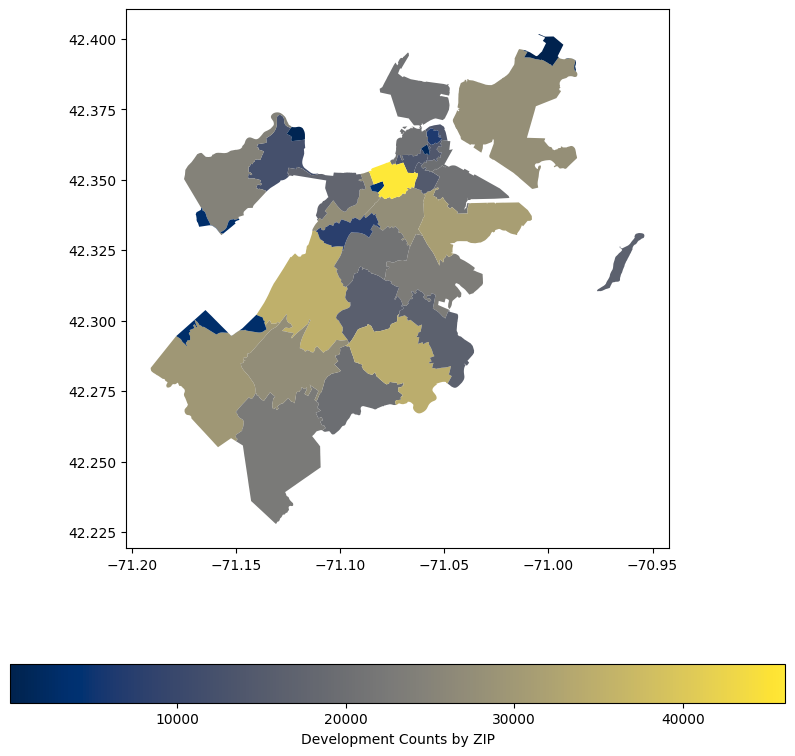

In [197]:
income = income.merge(num_per_neighborhood.rename("Development counts"), left_on="ZIP5", right_on=num_per_neighborhood.index)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
income.plot(column="Development counts", ax=ax, legend=True, cmap="cividis",\
                     legend_kwds={'label': "Development Counts by ZIP",
                         'orientation': "horizontal"})
fig.savefig("income_heat", bbox_inches='tight')

#### ZBA dataset for finding rejected developments (denied)

In [198]:
zba = pd.read_csv("./proj_data/zba.csv")

In [199]:
zba["decision"].value_counts()

AppProv       4580
Approved      2419
DeniedPrej     670
Denied         440
Withdrawn      251
                 4
Name: decision, dtype: int64

In [200]:
denied = zba[(zba["decision"] == "DeniedPrej") | (zba["decision"] == "Denied")] # rejected
denied["zip"]

317     2126
376     2128
435     2129
438     2131
442     2128
        ... 
9117    2111
9122    2118
9125    2125
9143    2131
9146    2132
Name: zip, Length: 1110, dtype: int64

Finding coordinates from Addresses

In [201]:
# need API key
from geopy.geocoders import GoogleV3
geolocator = GoogleV3()
location = geolocator.geocode("821 Cummins HWY Mattapan 02126")
location.latitude, location.longitude

Processing Income data from IRS.csv

In [202]:
def read_IRS(filename):
    data = []
    f = open(filename, "r", encoding="UTF-8")
    for line in f:
        line = line[:-1]
        if line[0] == '1' or line[0] == "2":
            if "under" not in line and "more" not in line:
                data.append("0" + line[:4] + '",' + line[11:-1])
    split_data = []
    for s in data:
        ss = s.split('",')
        if len(ss) == 2:
            s2 = ss[-1].split(',"')
            ss[-1] = s2[0]
            ss.extend(s2[1:])
        split_data.append([int(string.replace('"', '').replace(',', "")) if i != 0 else string for i, string in enumerate(ss)])
    return split_data
data = read_IRS("./proj_data/IRS.csv")
zip_inc = pd.DataFrame(data, columns=["ZIP", "number filed", "amount"])

In [203]:
zip_inc["Average Income"] = zip_inc["amount"] / zip_inc["number filed"]
zip_inc.sort_values(by="Average Income", ascending=False)

ZIP  number filed   amount  Average Income
400  02493          5190  1615196      311.213102
397  02481          6970  1985396      284.848780
277  02030          2840   728897      256.653873
398  02482          4960  1114975      224.793347
392  02468          2710   605529      223.442435
..     ...           ...      ...             ...
223  01840          3390    97643       28.803245
52   01107          4340   122699       28.271659
54   01109         12960   360861       27.844213
224  01841         28250   751227       26.592106
50   01105          4300    95376       22.180465

[480 rows x 4 columns]

In [204]:
income = income.merge(zip_inc, how="left", left_on="ZIP5", right_on="ZIP")

Text(0.5, 1.0, 'Per-capita Income by ZIP Code (in thousands of dollars)')

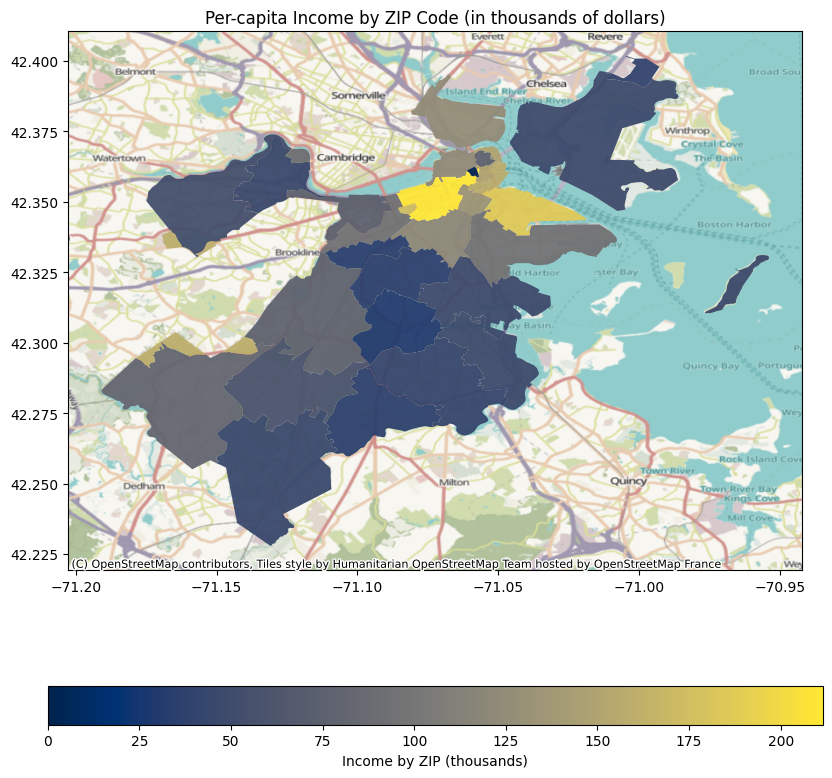

In [205]:
income["Average Income"].fillna(0, inplace=True)
fig, ax = plt.subplots(figsize=(10, 10))
income.plot(column="Average Income",ax=ax, alpha=0.95, legend=True, cmap="cividis",\
                     legend_kwds={'label': "Income by ZIP (thousands)",
                         'orientation': "horizontal"})
cx.add_basemap(ax, crs=income.crs)
ax.set_title("Per-capita Income by ZIP Code (in thousands of dollars)")


In [206]:
income.sort_values(by="Average Income", ascending=True, inplace=True)
# Exclude 02203 since no one lives there? City hall ZIP

Population by ZIP dataset (not used in final analysis)

In [207]:
zip_pop = pd.read_csv("./proj_data/Population_by_Income.csv")
r = lambda s: s.replace(",", "")
z = lambda i: "0" + str(i)
zip_pop["Population"] = zip_pop["Population"].apply(r)
zip_pop["Population"] = zip_pop["Population"].apply(int)
zip_pop["ZIP"] = zip_pop["ZIP"].apply(z)

In [208]:
zip_pop

ZIP  Population
0    01001       16088
1    01002       27323
2    01003       13711
3    01005        4947
4    01007       15304
..     ...         ...
534  02777       17020
535  02779        6724
536  02780       51911
537  02790       16237
538  02791         361

[539 rows x 2 columns]

In [209]:
income = income.merge(zip_pop, how="left", left_on="ZIP5", right_on="ZIP")

Text(0.5, 1.0, 'Population')

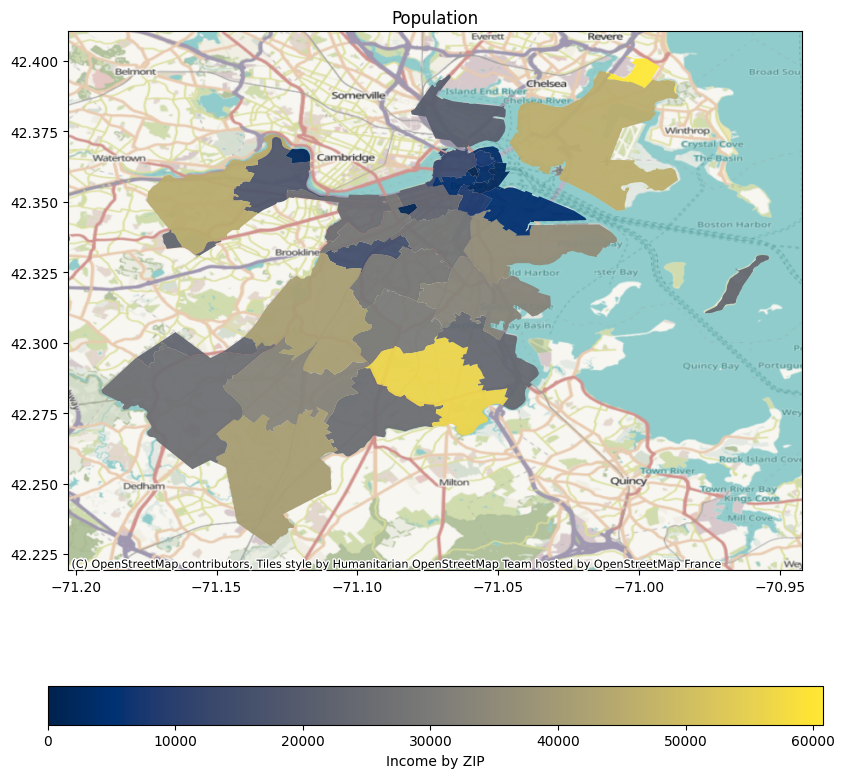

In [210]:
fig, ax = plt.subplots(figsize=(10, 10))
income.plot(column="Population",ax=ax, alpha=0.95, legend=True, cmap="cividis",\
                     legend_kwds={'label': "Income by ZIP",
                         'orientation': "horizontal"})
cx.add_basemap(ax, crs=income.crs)
ax.set_title("Population")


In [211]:
zips = zip(income["ZIP5"].to_list(), income["Average Income"].to_list(), income["Development counts"].to_list(), 
           income["Population"].to_list())
zips = list(zips)[1:]

In [212]:
z = pd.DataFrame(zips, columns=["ZIP", "Average Income", "Development Number", "Population"])
sums = {col: z[col].sum() for col in z.columns if col != "ZIP"}
sums

{'Average Income': 3858.2000267355543,
 'Development Number': 624489,
 'Population': 892163}

#### Overall Income Gini for Boston

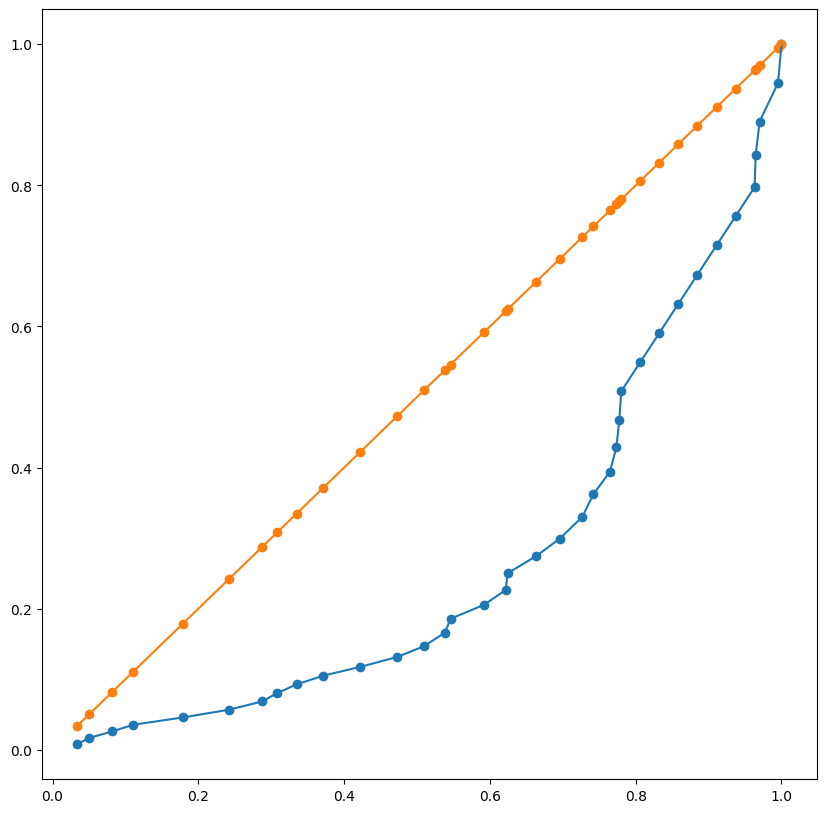

In [213]:
z.sort_values(by="Average Income", ascending=True, inplace=True)
sum_pop, sum_inc = 0, 0
ratios_pop, ratios_inc = [], []
for i, row in z.iterrows():
    sum_pop += row["Population"]
    sum_inc += row["Average Income"]
    r_pop = sum_pop / sums["Population"]
    r_inc = sum_inc / sums["Average Income"]
    ratios_pop.append(r_pop)
    ratios_inc.append(r_inc)
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(ratios_pop, ratios_inc)
ax.scatter(ratios_pop, ratios_inc)
ax.plot(ratios_pop, ratios_pop)
ax.scatter(ratios_pop, ratios_pop)

Gini coefficient

In [214]:
from sklearn.metrics import auc
lorenz = auc(ratios_pop, ratios_inc)
full = 0.5
gini = (full - lorenz) / full
gini

0.47991324874398844

Slightly worse than the US Gini of 0.47

#### Lorenz curv for approved requests by income

Text(0.5, 1.0, 'Lorenz Curve for Approved Requests by Income')

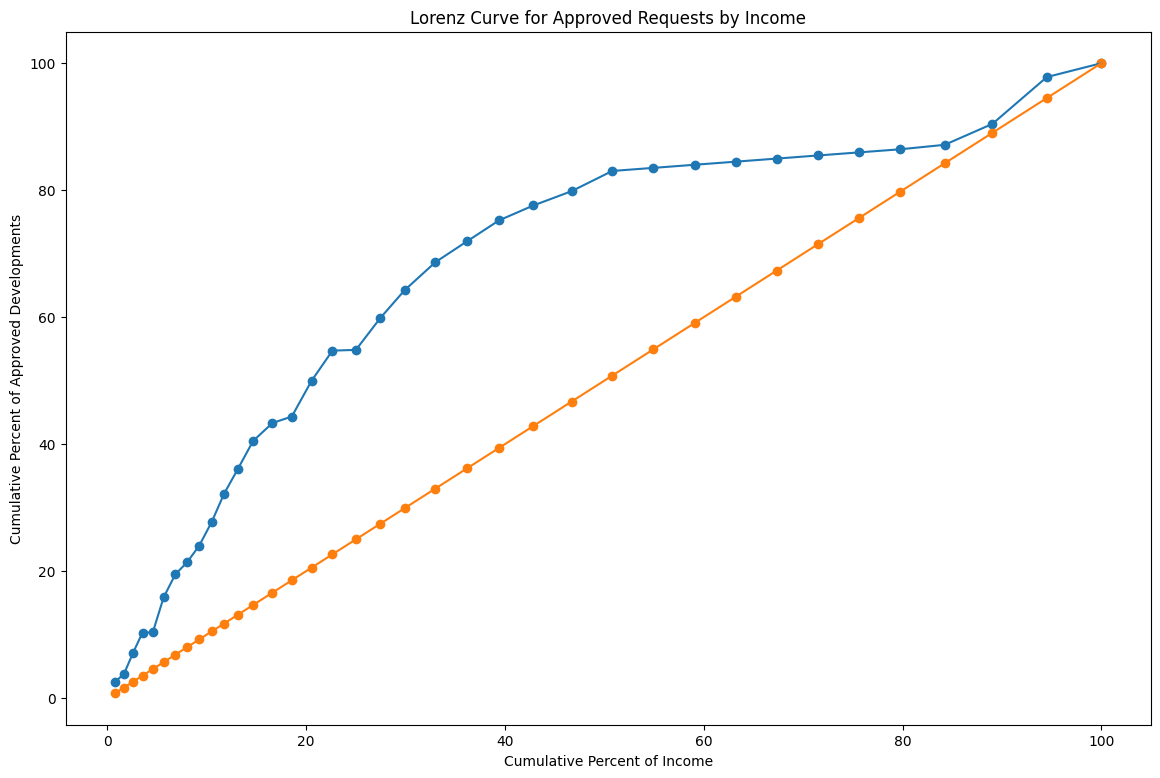

In [215]:
sum_inc, sum_dev = 0, 0
ratios_inc, ratios_dev = [], []
z.sort_values(by="Average Income", ascending=True, inplace=True)
for i, row in z.iterrows():
    sum_inc += row["Average Income"]
    sum_dev += row["Development Number"]
    r_inc = sum_inc / sums["Average Income"]
    r_dev = sum_dev / sums["Development Number"]
    ratios_inc.append(r_inc * 100)
    ratios_dev.append(r_dev * 100)
fig, ax = plt.subplots(figsize=(14, 9))
ax.plot(ratios_inc, ratios_dev)
ax.scatter(ratios_inc, ratios_dev)
ax.plot(ratios_inc, ratios_inc)
ax.scatter(ratios_inc, ratios_inc)
ax.set_xlabel("Cumulative Percent of Income")
ax.set_ylabel("Cumulative Percent of Approved Developments")
ax.set_title("Lorenz Curve for Approved Requests by Income")

Gini coefficient (negative since skewed towards lower income values)

In [216]:
lorenz = auc(ratios_inc, ratios_dev)
full = 5000
gini = (full - lorenz) / full
gini

-0.39506614201476914

Lorenz curve development number vs population by ZIP

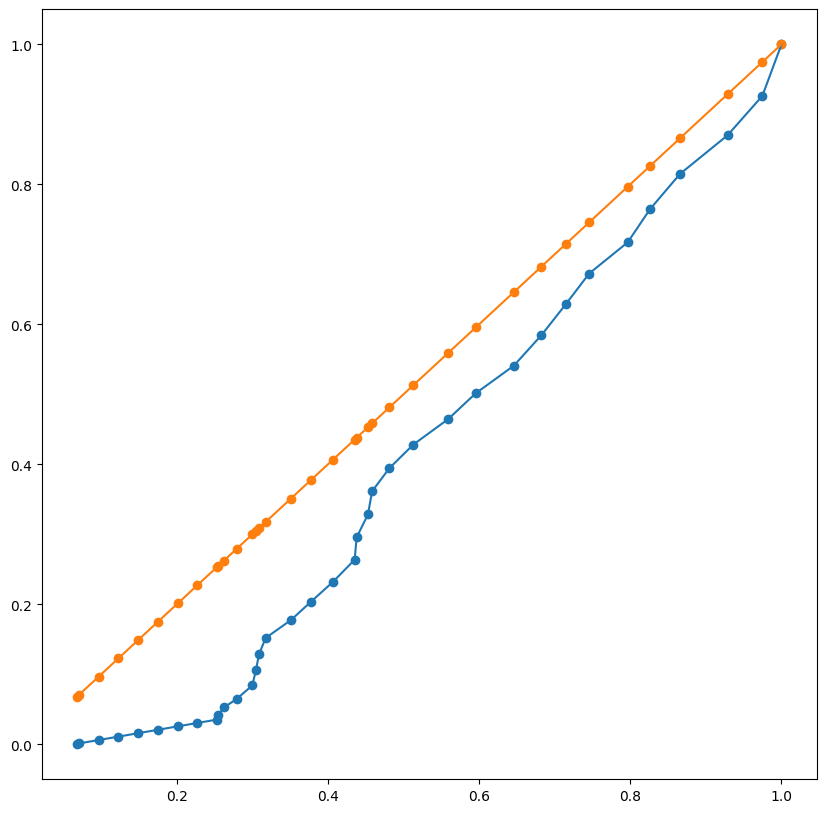

In [217]:
sum_pop, sum_dev = 0, 0
ratios_pop, ratios_dev = [], []
z.sort_values(by="Development Number", ascending=True, inplace=True)
for i, row in z.iterrows():
    sum_pop += row["Population"]
    sum_dev += row["Development Number"]
    r_pop = sum_pop / sums["Population"]
    r_dev = sum_dev / sums["Development Number"]
    ratios_pop.append(r_pop)
    ratios_dev.append(r_dev)
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(ratios_pop, ratios_dev)
ax.scatter(ratios_pop, ratios_dev)
ax.plot(ratios_pop, ratios_pop)
ax.scatter(ratios_pop, ratios_pop)

#### Extracting denied developments

In [219]:
denied["ZIP"]= denied["zip"].apply(lambda i: "0" + str(i))

C:\Users\efim6\AppData\Local\Temp\ipykernel_24712\1681722881.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  denied["ZIP"]= denied["zip"].apply(lambda i: "0" + str(i))


In [220]:
denied_counts = denied.groupby("zip")["decision"].count()
denied_counts.index= ["0" + str(i) for i in denied_counts.index]
len(denied_counts.index)

26

In [221]:
den_income = income[income["ZIP5"].isin(denied_counts.index)]

In [222]:
z = den_income.merge(denied_counts, how="left", left_on="ZIP5", right_on=denied_counts.index)
z.rename(columns={"decision": "denied counts"}, inplace=True)

In [223]:
sums_2 = {}
sums_2["denied counts"] = z["denied counts"].sum()
sums_2["Average Income"] = z["Average Income"].sum()
sums_2

{'denied counts': 1110, 'Average Income': 2252.135597989934}

Lorenz curve for rejected developments

Text(0.5, 1.0, 'Lorenz Curve for Rejected Requests by Income')

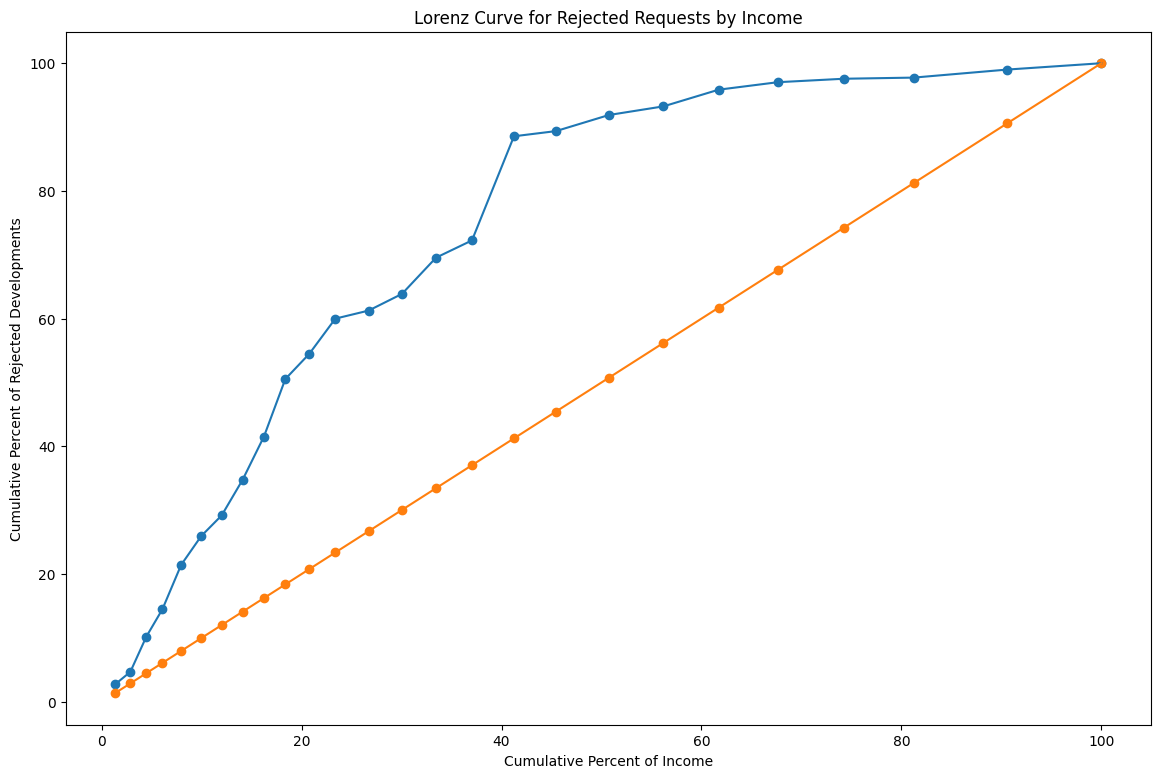

In [227]:
sum_inc, sum_dev = 0, 0
ratios_inc, ratios_dev = [], []
z.sort_values(by="Average Income", ascending=True, inplace=True)
for i, row in z.iterrows():
    sum_inc += row["Average Income"]
    sum_dev += row["denied counts"]
    r_inc = sum_inc / sums_2["Average Income"]
    r_dev = sum_dev / sums_2["denied counts"]
    ratios_inc.append(r_inc * 100)
    ratios_dev.append(r_dev * 100)
fig, ax = plt.subplots(figsize=(14, 9))
ax.plot(ratios_inc, ratios_dev)
ax.scatter(ratios_inc, ratios_dev)
ax.plot(ratios_inc, ratios_inc)
ax.scatter(ratios_inc, ratios_inc)
ax.set_xlabel("Cumulative Percent of Income")
ax.set_ylabel("Cumulative Percent of Rejected Developments")
ax.set_title("Lorenz Curve for Rejected Requests by Income")

In [225]:
lorenz = auc(ratios_inc, ratios_dev)
full = 5000
gini = (full - lorenz) / full
gini

-0.5121953415871833

In [226]:
list(zip(ratios_inc, ratios_dev))

[(1.335256524332415, 2.7027027027027026),
 (2.8738042561095827, 4.684684684684685),
 (4.468093669602605, 10.18018018018018),
 (6.0862186560356175, 14.504504504504503),
 (7.958080479185413, 21.44144144144144),
 (9.962372755602908, 25.945945945945947),
 (12.011897525082764, 29.18918918918919),
 (14.108418131793524, 34.77477477477478),
 (16.237224153810402, 41.53153153153153),
 (18.376204736252422, 50.54054054054053),
 (20.78102524437175, 54.5045045045045),
 (23.37888623082312, 60.0),
 (26.708384156271336, 61.261261261261254),
 (30.044473355085216, 63.873873873873876),
 (33.45112537334408, 69.54954954954955),
 (37.04607030272663, 72.25225225225225),
 (41.24688687817164, 88.55855855855856),
 (45.44832408833345, 89.36936936936937),
 (50.74936170305349, 91.8918918918919),
 (56.19946615769672, 93.24324324324324),
 (61.72173547096269, 95.85585585585585),
 (67.63703632251281, 97.02702702702702),
 (74.2268570351585, 97.56756756756756),
 (81.22985590913618, 97.74774774774775),
 (90.6118861323442,

Bottom 50% accounts for 92% of denied decisions.